# Conditional Variational Autoencoder (CVAE)

Train a CVAE on MNIST and generate digits conditioned on labels.

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:

class CVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10, label_dim=10):
        super().__init__()
        self.encoder_fc = nn.Linear(input_dim + label_dim, 256)
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + label_dim, 256)
        self.out = nn.Linear(256, input_dim)

    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1)
        h = torch.relu(self.encoder_fc(xy))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h = torch.relu(self.decoder_fc(zy))
        return torch.sigmoid(self.out(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar


In [3]:

def cvae_loss(x, x_hat, mu, logvar, beta=1):
    recon = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl


In [4]:

transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


In [5]:

model = CVAE(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
beta = 1

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.view(x.size(0), -1).to(device)
        y_onehot = torch.nn.functional.one_hot(y, num_classes=10).float().to(device)

        x_hat, mu, logvar = model(x, y_onehot)
        loss = cvae_loss(x, x_hat, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 173.0819
Epoch 2, Loss: 127.0702
Epoch 3, Loss: 120.0545
Epoch 4, Loss: 116.3926
Epoch 5, Loss: 113.8409
Epoch 6, Loss: 112.0203
Epoch 7, Loss: 110.6005
Epoch 8, Loss: 109.4971
Epoch 9, Loss: 108.5731
Epoch 10, Loss: 107.8451


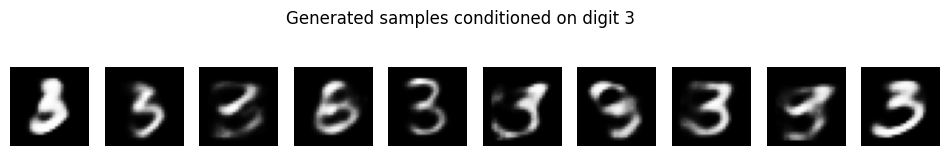

In [6]:

model.eval()
digit = 3  # change digit 0-9

y = torch.zeros(10, 10).to(device)
y[:, digit] = 1

z = torch.randn(10, 10).to(device)

with torch.no_grad():
    samples = model.decode(z, y)

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i in range(10):
    axes[i].imshow(samples[i].view(28, 28).cpu(), cmap="gray")
    axes[i].axis("off")

plt.suptitle(f"Generated samples conditioned on digit {digit}")
plt.show()
